In [1]:
import numpy as np
import time
import pickle
from matplotlib import pyplot as plt

import tensorflow as tf

import tensorflow_addons as tfa
import tensorflow.keras as keras
import tensorflow_datasets as tfds

In [ ]:
### information of gpu in colab
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [2]:
tf.random.set_seed(9)

## Select your dataset here:
apple2orange, summer2winter_yosemite, horse2zebra, monet2photo, ...

See datasets [here](https://people.eecs.berkeley.edu/%7Etaesung_park/CycleGAN/datasets/).

In [3]:
## loading dataset from tensorflow_datasets
dataset, metadata = tfds.load('cycle_gan/vangogh2photo',
                              with_info=True, as_supervised=True, )

trainB, trainA = dataset['trainA'], dataset['trainB']
testB, testA = dataset['testA'], dataset['testB']

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/vangogh2photo/2.0.0.incompleteJ8NY6C/cycle_gan-trainA.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/vangogh2photo/2.0.0.incompleteJ8NY6C/cycle_gan-trainB.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/vangogh2photo/2.0.0.incompleteJ8NY6C/cycle_gan-testA.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/vangogh2photo/2.0.0.incompleteJ8NY6C/cycle_gan-testB.tfrecord


Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/vangogh2photo/2.0.0. Subsequent calls will reuse this data.


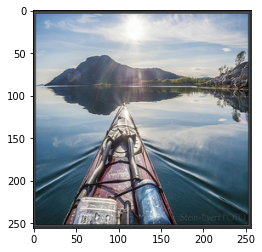

(256, 256, 3)


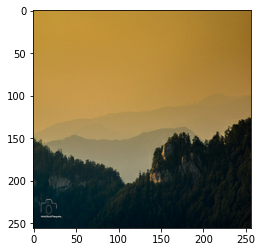

(256, 256, 3)


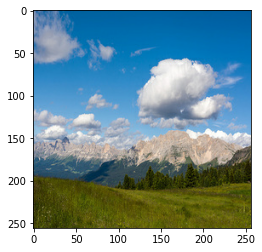

(256, 256, 3)


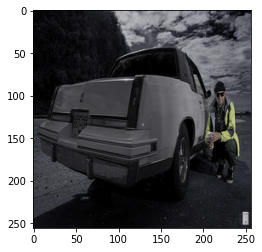

(256, 256, 3)


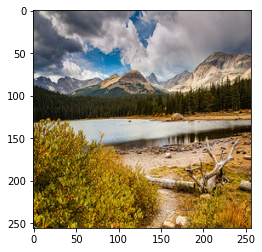

(256, 256, 3)


In [ ]:
for y in trainA.take(5):
    plt.imshow(y[0])
    plt.show()
    print(y[0].shape)

## Set the images resolution here

64, 128, 256, ...

In [4]:
IMG_HEIGHT = IMG_WIDTH = 256

batch_size = 1
BUFFER_SIZE = 1000

In [5]:
def resize(image):
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return image

def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

def random_jitter(image):
  if IMG_HEIGHT==256:
      jitter = 286
  if IMG_HEIGHT==128:
      jitter = 144
    
  image = tf.image.resize(image, [jitter, jitter],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  image = random_crop(image)
  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

def preprocess_image(image, label):
  image = random_jitter(image)
  image = normalize(image)

  return image

In [6]:
tfds.disable_progress_bar()
AUTOTUNE = tf.data.experimental.AUTOTUNE

## preprocess_image: (for 128*128 images)
# 1) resizing 128*128*3 images to 144*144*3
# 2) cropping them into 128*128*3 images
# 3) randomly flipping images 
# 4) normalizing the images values from [0, 255] to [-1, 1]

trainA = trainA.map(
    preprocess_image, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(batch_size)

trainB = trainB.map(
    preprocess_image, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(batch_size)

testA = testA.map(
    preprocess_image, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(batch_size)

testB = testB.map(
    preprocess_image, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(batch_size)

In [7]:
# select one sample
sampleA = next(iter(trainA))
sampleB = next(iter(trainB))

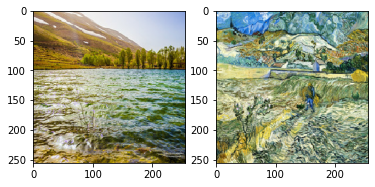

In [8]:
plt.subplot(121)
plt.imshow(sampleA[0] * 0.5 + 0.5)

plt.subplot(122)
plt.imshow(sampleB[0] * 0.5 + 0.5)
plt.show()

In [9]:
def _get_norm_layer(norm):
    if norm == 'none':
        return lambda: lambda x: x
    elif norm == 'batch_norm':
        return keras.layers.BatchNormalization
    elif norm == 'instance_norm':
        return tfa.layers.InstanceNormalization
    elif norm == 'layer_norm':
        return keras.layers.LayerNormalization


### paper: The weights are initialized from a zero-centered normal distribution with a 
### standard deviation of 0.02
weight_init = tf.random_normal_initializer(mean=0.0, stddev=0.02)
initializer = weight_init

In [10]:
def Generator(input_shape=(256, 256, 3),
                    output_channels=3,
                    dim=64,
                    n_downsamplings=2,
                    n_blocks=9,
                    norm='instance_norm'):
    Norm = _get_norm_layer(norm)


    # Rk denotes a residual block that contains two 3 × 3 convolutional layers with the same number of filters on both layer.
    def _residual_block(x):
        dim = x.shape[-1]
        h = x

        h = tf.pad(h, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='REFLECT')
        h = keras.layers.Conv2D(dim, 3, padding='valid', use_bias=False, kernel_initializer=initializer)(h)
        h = Norm()(h)
        h = tf.nn.relu(h)

        h = tf.pad(h, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='REFLECT')
        h = keras.layers.Conv2D(dim, 3, padding='valid', use_bias=False, kernel_initializer=initializer)(h)
        h = Norm()(h)

        return keras.layers.add([x, h])

    # 0
    h = inputs = keras.Input(shape=input_shape)


    # c7s1-k denote a 7 × 7 Convolution-InstanceNorm-ReLU layer with k filters and stride 1
    # 1 = c7s1-64
    h = tf.pad(h, [[0, 0], [3, 3], [3, 3], [0, 0]], mode='REFLECT')      # Reflection padding was used to reduce artifacts.
    h = keras.layers.Conv2D(dim, 7, padding='valid', use_bias=False, kernel_initializer=initializer)(h)  ## number of channels = dim (default=64)
    h = Norm()(h)
    h = tf.nn.relu(h)

    #dk denotes a 3 × 3 Convolution-InstanceNorm-ReLU layer with k filters and stride 2
    # 2 = d128
    for _ in range(n_downsamplings):
        dim *= 2
        h = keras.layers.Conv2D(dim, 3, strides=2, padding='same', use_bias=False, kernel_initializer=initializer)(h)
        h = Norm()(h)
        h = tf.nn.relu(h)

    # 3 = n_blocks of R256
    for _ in range(n_blocks):
        h = _residual_block(h)


    # uk denotes a 3 × 3 fractional-strided-Convolution-InstanceNorm-ReLU layer with k filters and stride 1/2 .
    # 4 = u128 -> u64
    for _ in range(n_downsamplings):
        dim //= 2
        h = keras.layers.Conv2DTranspose(dim, 3, strides=2, padding='same', use_bias=False, kernel_initializer=initializer)(h)
        h = Norm()(h)
        h = tf.nn.relu(h)

    # 5 = c7s1-3
    h = tf.pad(h, [[0, 0], [3, 3], [3, 3], [0, 0]], mode='REFLECT')
    h = keras.layers.Conv2D(output_channels, 7, padding='valid', kernel_initializer=initializer)(h)
    h = tf.tanh(h)

    return keras.Model(inputs=inputs, outputs=h)

In [11]:
def Discriminator(input_shape=(256, 256, 3),
                      dim=64,
                      n_downsamplings=3,
                      norm='instance_norm'):  ### 70 × 70 PatchGAN
    dim_ = dim
    Norm = _get_norm_layer(norm)

    # 0
    h = inputs = keras.Input(shape=input_shape)

    # We use leaky ReLUs with a slope of 0.2.
    
    # Ck denotes a 4 × 4 Convolution-InstanceNorm-LeakyReLU layer with k filters and stride 2
    # 1 = C64, We do not use InstanceNorm for the first C64 layer.
    h = keras.layers.Conv2D(dim, 4, strides=2, padding='same', kernel_initializer=initializer)(h)
    h = tf.nn.leaky_relu(h, alpha=0.2)

    # -> C128 -> C256
    for _ in range(n_downsamplings - 1):
        dim = min(dim * 2, dim_ * 8)
        h = keras.layers.Conv2D(dim, 4, strides=2, padding='same', use_bias=False, kernel_initializer=initializer)(h)
        h = Norm()(h)
        h = tf.nn.leaky_relu(h, alpha=0.2)

    # 2 = C512
    dim = min(dim * 2, dim_ * 8)
    h = keras.layers.Conv2D(dim, 4, strides=1, padding='same', use_bias=False, kernel_initializer=initializer)(h)
    h = Norm()(h)
    h = tf.nn.leaky_relu(h, alpha=0.2)

    # 3 = After the last layer, we apply a convolution to produce a 1-dimensional output.
    h = keras.layers.Conv2D(1, 4, strides=1, padding='same', kernel_initializer=initializer)(h)

    return keras.Model(inputs=inputs, outputs=h)

In [12]:
### Paper: to reduce model oscillation, we follow Shrivastava et al.’s strategy and update the 
### discrimiators using a history of generated images rather than the ones produced by the latest 
### generators. We keep an image buffer that stores the 50 previously created images.

## pool size = 50 (50 previously created images)
class ItemPool:

    def __init__(self, pool_size=50):
        self.pool_size = pool_size
        self.items = []

    def __call__(self, in_items):
        # `in_items` should be a batch tensor

        if self.pool_size == 0:
            return in_items

        out_items = []
        for in_item in in_items:
            if len(self.items) < self.pool_size:
                self.items.append(in_item)
                out_items.append(in_item)
            else:
                if np.random.rand() > 0.5:
                    idx = np.random.randint(0, len(self.items))
                    out_item, self.items[idx] = self.items[idx], in_item
                    out_items.append(out_item)
                else:
                    out_items.append(in_item)
        return tf.stack(out_items, axis=0)

In [13]:
### We use 6 blocks for 128 × 128 images and 9 blocks for 256 × 256 and higher-
### resolution training images.


if IMG_HEIGHT >= 256:
    numberOfblocks = 9
else:
    numberOfblocks = 6

GXY = Generator(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                    output_channels=3,
                    dim=64,
                    n_downsamplings=2,
                    n_blocks=numberOfblocks,
                    norm='instance_norm')

FYX = Generator(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                    output_channels=3,
                    dim=64,
                    n_downsamplings=2,
                    n_blocks=numberOfblocks,
                    norm='instance_norm')
    
DY = Discriminator(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                      dim=64,
                      n_downsamplings=3,
                      norm='instance_norm')
DX = Discriminator(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))


pool_size = 50
XY_pool = ItemPool(pool_size)
YX_pool = ItemPool(pool_size)

In [ ]:
GXY.summary()

In [ ]:
DY.summary()

In [14]:
def Generator_adversarial_loss(D_fake_y, D_fake_x): ### Mean Squared Error
    G_loss = tf.reduce_mean((D_fake_y - 1.)**2)
    F_loss = tf.reduce_mean((D_fake_x - 1.)**2)

    return G_loss + F_loss


def Cycle_loss(x, cycle_x, y, cycle_y):
    # cycle_x_loss = tf.losses.MeanAbsoluteError(x, cycle_x)
    cycle_x_loss = tf.reduce_mean(tf.abs(x - cycle_x))
    cycle_y_loss = tf.reduce_mean(tf.abs(y - cycle_y))
    
    return cycle_x_loss + cycle_y_loss

def Identity_loss(x, identity_x, y, identity_y): ## The identity mapping loss helps preserve the color of the input paintings.
    
    identity_x_loss = tf.reduce_mean(tf.abs(x - identity_x)) 
    identity_y_loss = tf.reduce_mean(tf.abs(y - identity_y)) 

    return identity_x_loss + identity_y_loss

def Discriminator_loss(D_real, D_fake):
    disc_loss = tf.reduce_mean((D_real - 1.)**2) + tf.reduce_mean((D_fake)**2)
    return disc_loss

In [15]:
def generate_images(model, image):
  prediction = model(image)
    
  plt.figure(figsize=(12, 12))

  display_list = [image[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

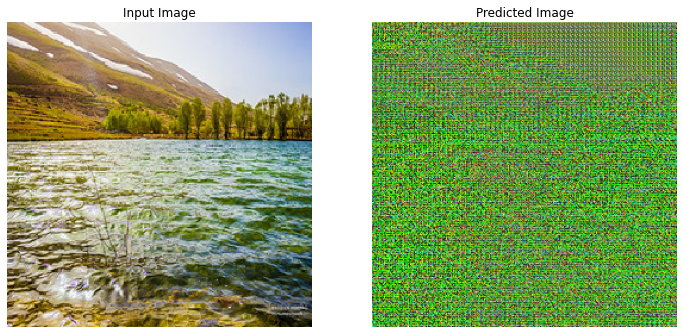

In [16]:
generate_images(GXY, sampleA)

In [17]:
class LinearDecay(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, initial_learning_rate, total_steps, step_decay):
        super(LinearDecay, self).__init__()
        self._initial_learning_rate = initial_learning_rate
        self._steps = total_steps
        self._step_decay = step_decay
        self.current_learning_rate = tf.Variable(initial_value=initial_learning_rate, trainable=False, dtype=tf.float32)

    def __call__(self, step):
        self.current_learning_rate.assign(tf.cond(
            step >= self._step_decay,
            true_fn=lambda: self._initial_learning_rate * (1 - 1 / (self._steps - self._step_decay) * (step - self._step_decay)),
            false_fn=lambda: self._initial_learning_rate
        ))
        return self.current_learning_rate

In [18]:
## We train our networks from scratch, with a learning rate of 0.0002. 
## We keep the same learning rate for the first 100 epochs and linearly
## decay the rate to zero over the next 100 epochs.

lr =  0.0002
total_epochs = 200
decay_epoch = 100

n_steps = len(list(tf.data.Dataset.zip((trainA, trainB)))) # number of batches in each epoch

G_lr_scheduler = LinearDecay(lr, total_epochs * n_steps, decay_epoch * n_steps)
D_lr_scheduler = LinearDecay(lr, total_epochs * n_steps, decay_epoch * n_steps)

In [19]:
beta1 = 0.5
G_optimizer = keras.optimizers.Adam(learning_rate=G_lr_scheduler, beta_1=beta1)
D_optimizer = keras.optimizers.Adam(learning_rate=D_lr_scheduler, beta_1=beta1)

In [20]:
### Monet’s paintings→photos
## The weight for the identity mapping loss was 0.5λ where λ 
## was the weight for cycle consistency loss. We set λ = 10.
cycle_loss_weight = 10.

### use identity loss only for painting→photo datasets such as monet2photo, cezanne2photo, vangogh2photo, and ...
Identity_loss_weight = cycle_loss_weight * 0.5

In [21]:
@tf.function
def train_G(x, y):

    with tf.GradientTape() as generator_tape:
        y_gen = GXY(x)
        x_gen = FYX(y)

        cycle_x = FYX(y_gen)
        cycle_y = GXY(x_gen)

        identity_x = FYX(x)
        identity_y = GXY(y)

        D_fake_y = DY(y_gen)
        D_fake_x = DX(x_gen)

        Generator_loss = Generator_adversarial_loss(D_fake_y, D_fake_x)
        total_cycle_loss = Cycle_loss(x, cycle_x, y, cycle_y)

        ### note: only for painting→photo datasets
        total_identity_loss = Identity_loss(x, identity_x, y, identity_y)
        Total_Generator_loss = Generator_loss + cycle_loss_weight * total_cycle_loss + Identity_loss_weight * total_identity_loss
        ### for other dataset comment total_identity_loss and use this line for Total_Generator_loss
        ### Total_Generator_loss = Generator_loss + cycle_loss_weight * total_cycle_loss
    
    ### update G
    G_gradients = generator_tape.gradient(Total_Generator_loss, GXY.trainable_variables + FYX.trainable_variables)
    G_optimizer.apply_gradients(zip(G_gradients, GXY.trainable_variables + FYX.trainable_variables))

    return Total_Generator_loss, x_gen, y_gen

In [22]:
@tf.function
def train_D(x, y, x_gen, y_gen):

    with tf.GradientTape() as discriminator_tape:

        D_real_y = DY(y) 
        D_fake_y = DY(y_gen)

        D_real_x = DX(x) 
        D_fake_x = DX(x_gen)
        
        DY_loss = Discriminator_loss(D_real_y, D_fake_y)
        DX_loss = Discriminator_loss(D_real_x, D_fake_x)

        Total_Discriminator_loss = DY_loss + DX_loss
    
    D_gradients = discriminator_tape.gradient(Total_Discriminator_loss, DY.trainable_variables + DX.trainable_variables)
    D_optimizer.apply_gradients(zip(D_gradients, DY.trainable_variables + DX.trainable_variables))

    return Total_Discriminator_loss

In [23]:
def train_step(x, y):

    G_loss, x_hat, y_hat = train_G(x, y)

    y_hat = XY_pool(y_hat) 
    x_hat = YX_pool(x_hat)  

    D_loss = train_D(x, y, x_hat, y_hat)

    return G_loss, D_loss

In [24]:
!mkdir images

In [25]:
def save_images(X, Y, epoch):
    Y_GEN = GXY(X)
    X_GEN = FYX(Y)
    # plt.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
    
    display_list_X = [X[0], Y_GEN[0]]
    display_list_Y = [Y[0], X_GEN[0]]
    title = ['Input Image', 'Predicted Image']

    plt.figure(figsize=(10.0, 5.0))
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i], fontsize=14)
        plt.imshow(display_list_X[i] * 0.5 + 0.5)
        plt.axis('off')
    
    plt.savefig('./images/X2Y-' + str(epoch) + '.png')
    plt.close()

    plt.figure(figsize=(10.0, 5.0))
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i], fontsize=14)
        plt.imshow(display_list_Y[i] * 0.5 + 0.5)
        plt.axis('off')
    
    plt.savefig('./images/Y2X-' + str(epoch) + '.png')
    plt.close()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

### Create a folder in your Google Drive and save the model every 5 epochs

In [27]:
checkpoint_path = '/content/gdrive/My Drive/CycleGAN/m2v/'

ckpt = tf.train.Checkpoint(GXY=GXY,
                           FYX=FYX,
                           DX=DX,
                           DY=DY,
                           G_optimizer=G_optimizer,
                           D_optimizer=D_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')


Latest checkpoint restored!!


##### In the paper they train the model for 200 epochs.

In [28]:
EPOCHS = 200

In [ ]:
GLoss = []
DLoss = []

offset = 0 ### when you save the model and want to resume the training later
### should be zero at first

t1 = time.time()
for epoch_ in range(EPOCHS):

    epoch = epoch_ + offset

    start = time.time()

    Gcost = []
    Dcost = []
    
    n = 0
    for image_x, image_y in tf.data.Dataset.zip((trainA, trainB)):
        G_loss, D_loss = train_step(image_x, image_y)
        Gcost.append(np.average(G_loss))
        Dcost.append(np.average(D_loss))

        if n % 100 == 0:
            print ('.', end='')
        n+=1

    DLoss.append(np.average(Dcost))
    GLoss.append(np.average(Gcost))

    # if (epoch) % 2 == 0:
    generate_images(GXY, sampleA)
    
    if (epoch + 1) % 4 == 0:
        save_images(sampleA, sampleB, epoch=epoch + 1)
 
    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

t2 = time.time()

### Plot Loss

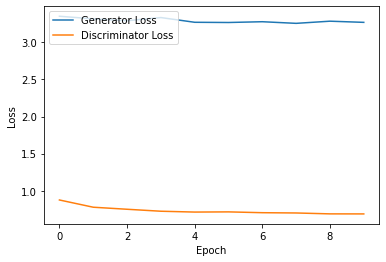

In [30]:
def plot(gen_loss, disc_loss):

    plt.plot(gen_loss, label='Generator Loss')
    plt.plot(disc_loss, label='Discriminator Loss')
    plt.legend(loc=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()


plot(GLoss, DLoss)

In [31]:
def X2Y(X_image):

    Y_GEN = GXY(X_image)
    X_CYCLE = FYX(Y_GEN)
    plt.figure(figsize=(16, 16))

    display_list = [X_image[0], Y_GEN[0], X_CYCLE[0]]
    title = ['Input Image', 'Predicted Image', 'Cycled Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()


def Y2X(Y_image):

    X_GEN = FYX(Y_image)
    Y_CYCLE = GXY(X_GEN)
    plt.figure(figsize=(16, 16))

    display_list = [Y_image[0], X_GEN[0], Y_CYCLE[0]]
    title = ['Input Image', 'Predicted Image', 'Cycled Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

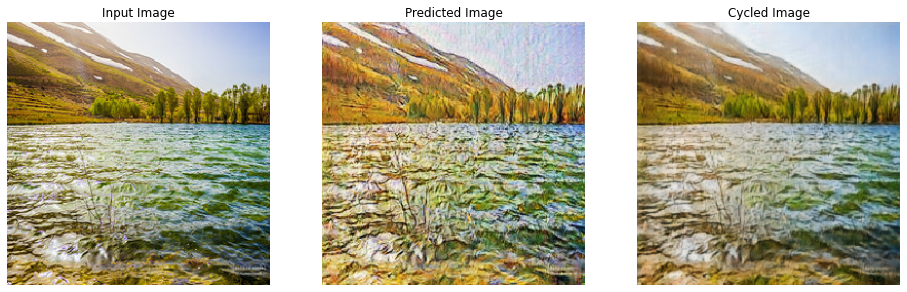

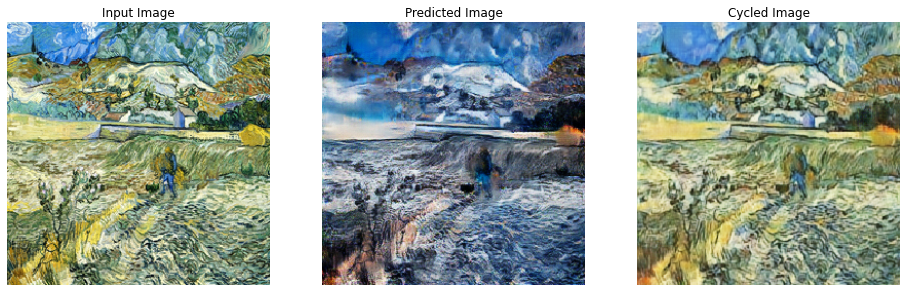

In [32]:
X2Y(sampleA)
Y2X(sampleB)

In [33]:
As = []
Bs = []
for _ in range(6):
    Bs.append(next(iter(trainB)))
    As.append(next(iter(trainA)))

pred_A = []
pred_B = []

for i in range(6):
    pred_A.append(GXY(As[i]))
    pred_B.append(FYX(Bs[i]))

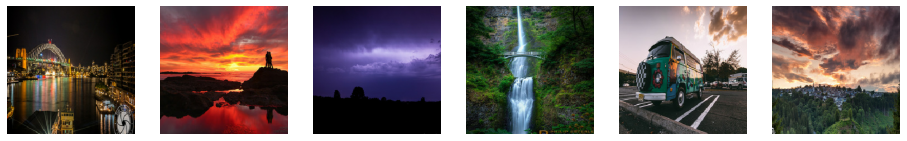

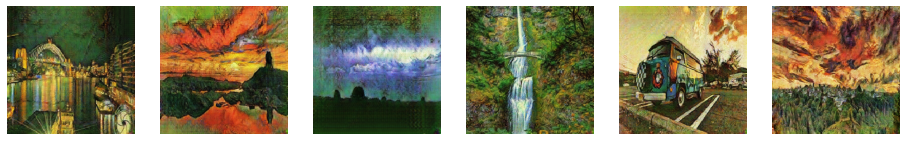

In [34]:
plt.figure(figsize=(16, 16))

for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(As[i][0] * 0.5 + 0.5)
    plt.axis('off')
plt.show()

plt.figure(figsize=(16, 16))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.imshow(pred_A[i][0] * 0.5 + 0.5)
    plt.axis('off')
plt.show()

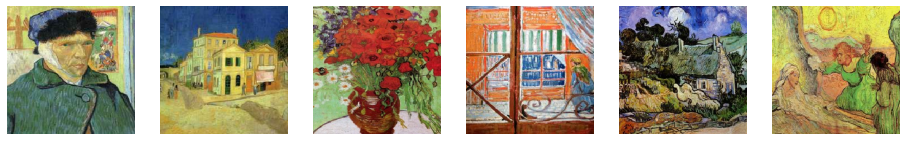

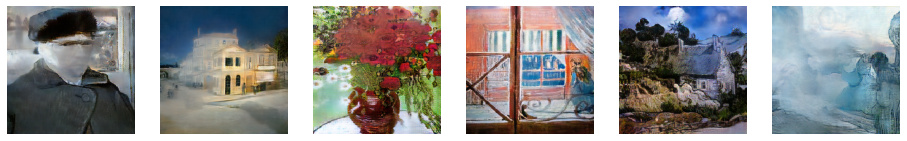

In [35]:
plt.figure(figsize=(16, 16))

for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(Bs[i][0] * 0.5 + 0.5)
    plt.axis('off')
plt.show()

plt.figure(figsize=(16, 16))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.imshow(pred_B[i][0] * 0.5 + 0.5)
    plt.axis('off')
plt.show()

### generate and save some samples

In [36]:
def generate_results(n=20):
    As = []
    Bs = []

    for _ in range(4*n):
        Bs.append(next(iter(trainB)))
        As.append(next(iter(trainA)))


    pred_A = []
    pred_B = []

    for i in range(4*n):
        pred_A.append(GXY(As[i]))
        pred_B.append(FYX(Bs[i]))

    for j in range(n):
        plt.figure(figsize=(10.0, 5.0))

        for i in range(4):
            plt.subplot(2, 4, i+1)
            plt.imshow(As[i + j * 4][0] * 0.5 + 0.5)
            plt.axis('off')

        for i in range(4):
            plt.subplot(2, 4, i+1 + 4)
            plt.imshow(pred_A[i + j * 4][0] * 0.5 + 0.5)
            plt.axis('off')
        plt.savefig('./images/A2B-' + str(j) + '.png')
        plt.close()


        plt.figure(figsize=(10.0, 5.0))
        
        for i in range(4):
            plt.subplot(2, 4, i+1)
            plt.imshow(Bs[i + j * 4][0] * 0.5 + 0.5)
            plt.axis('off')

        for i in range(4):
            plt.subplot(2, 4, i+1 + 4)
            plt.imshow(pred_B[i + j * 4][0] * 0.5 + 0.5)
            plt.axis('off')
        plt.savefig('./images/B2A-' + str(j) + '.png')
        plt.close()
            

In [37]:
generate_results(5)

In [ ]:
!zip -r /content/images.zip /content/images

### Give your image to the network
Upload an image in colab and load it with "imread"


In [39]:
import matplotlib

In [40]:
def res(image):
    image = (image / 127.5) - 1

    image = tf.image.resize(image, [IMG_HEIGHT, IMG_HEIGHT],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = tf.reshape(image, [1, IMG_HEIGHT, IMG_HEIGHT, 3])
    return image

In [41]:
img = matplotlib.image.imread('/content/6.jpeg')

In [42]:
img = res(img)

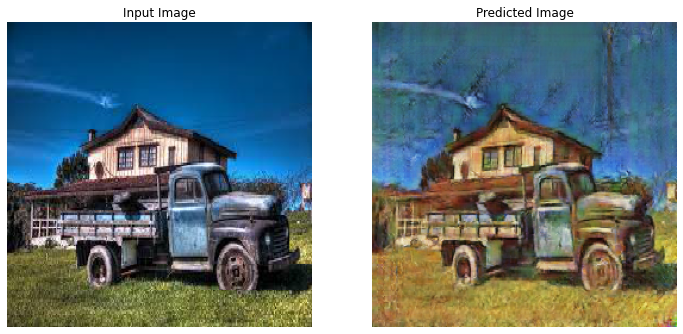

In [43]:
generate_images(GXY, img)